# Tutorial on how to implement simple decoding, using a quantum code with its encoding circuit
With help from some nifty functions from the `QuantumClifford.jl` library, this notebook will demonstrate and walk the reader through simulating simple errors on quantum circuits, followed then by how to evaluate that circuit's performance, assuming the encoding circuit is available.

In [1]:
using Revise
@time using QuantumClifford
@time using Quantikz
@time using QuantumClifford.ECC: Steane7, Shor9, naive_syndrome_circuit, encoding_circuit, parity_checks, code_s, code_n
versioninfo()
#@time using CircuitCompilation2xn
#include("../CircuitCompilation2xn/src/test_CC2xn.jl")

  1.076156 seconds (2.13 M allocations: 139.355 MiB, 4.42% gc time, 1.98% compilation time)


  0.143878 seconds (237.56 k allocations: 14.265 MiB, 1.62% compilation time)
  0.000180 seconds (219 allocations: 18.422 KiB)


Julia Version 1.9.2
Commit e4ee485e909 (2023-07-05 09:39 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 10 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores
Environment:
  JULIA_NUM_THREADS = 


## First we need a code (and a decoder)
Quantum Clifford's ECC submodule has a few famous codes already baked in, as well as a variety of helpful functions to make working with those codes as simple as (at least the authors thought) possible. Below, we declare an instance of the Steane 7 qubit code.

In [2]:
code = Steane7()

Steane7()

So now we have an instance of a somewhat opaque object, namely it's a subtype of the ECC submodule's `AbstractECC` type. In order to make this object more useful we will need to employ some of `QuantumClifford.ECC`'s other functions:
*  `parity_checks()`
    *  Returns the parity checks for the provided code, in the form of a Stabilizer tableau. Takes an `AbstractECC` type.
*  `naive_syndrome_circuit()`
    *  Returns the syndrome circuit for the provided code in the form of a vector of `QuantumClifford.AbstractOperation`. 
        *  **Note**: This function can take either an `AbstractECC` object like `Steane7()`, or a `Stabilizer` object like `parity_checks(Steane7())`.
        *  **Note**: By importing Quantikz via `using Quantikz` (done above), the REPL output (and this notebook) will be an image instead of seeing the vector.
*  `encoding_circuit()`
    *  Returns the encoding circuit for the provided code, in a similiar fashion to `naive_syndrome_circuit()`. However, for now this only takes an `AbstractECC` type, but hopefully this changes in the near future!

In [3]:
checks = parity_checks(code)

+ ___XXXX
+ _XX__XX
+ X_X_X_X
+ ___ZZZZ
+ _ZZ__ZZ
+ Z_Z_Z_Z

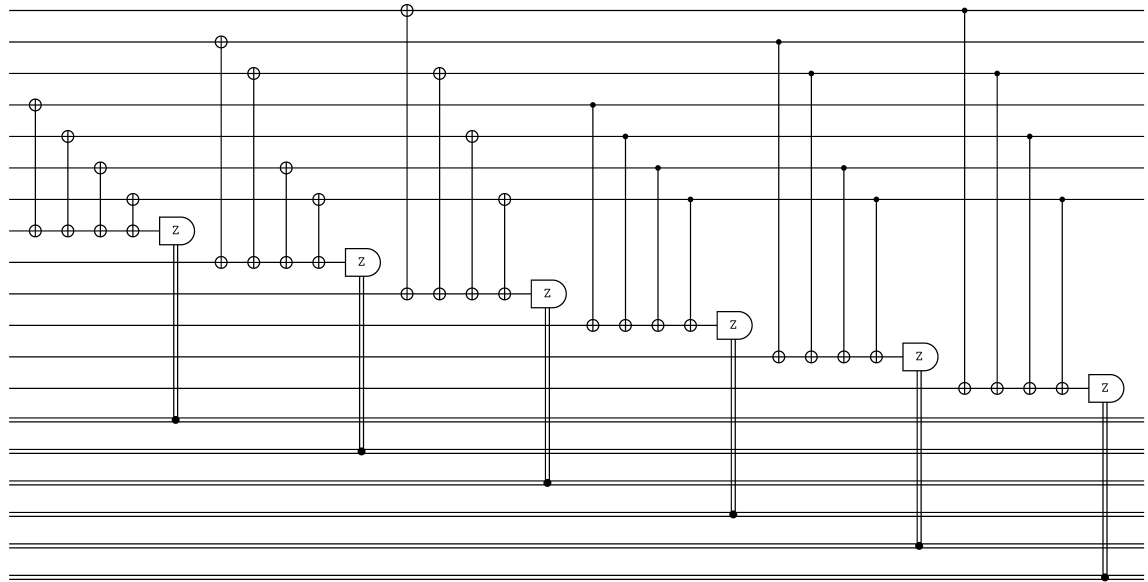

In [4]:
scirc = naive_syndrome_circuit(checks)

In [5]:
print(scirc) # If using Quantikz, above will be image of the circuit. This cell shows what it actually is 

QuantumClifford.AbstractOperation[

sXCX(4,8), sXCX(5,8), sXCX(6,8), sXCX(7,8), 

sMRZ(8, 1), sXCX(2,9), sXCX(3,9), sXCX(6,9), sXCX(7,9), sMRZ(9, 2), sXCX(1,10), sXCX(3,10), sXCX(5,10), sXCX(7,10), sMRZ(10, 3), sCNOT(4,11), sCNOT(5,11), sCNOT(6,11), sCNOT(7,11), sMRZ(11, 4), sCNOT(2,12), sCNOT(3,12), sCNOT(6,12), sCNOT(7,12), sMRZ(12, 5), sCNOT(1,13), sCNOT(3,13), sCNOT(5,13), sCNOT(7,13), sMRZ(13, 6)]

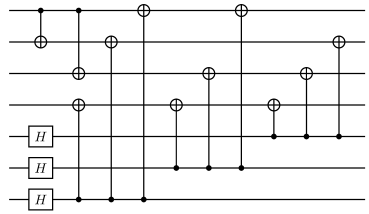

In [6]:
ecirc = encoding_circuit(code)

Using the parity checks we now have, we will create a very simple decoder. The end result will be a dictionary that we can provide a syndrome (the measurements from `scirc`) to, and it will give us the most likely error that occured. This dictionary decoder could be replaced with a more sophisticated decoder. Some points about the `create_lookup_table()` function:
*  This function generates all possible single qubit pauli errors for the provided code. In total the dictionary will have $3 \times n + 1$ entries in it. 3 is from the types of pauli errors, $X$, $Y$, and $Z$. $n$ is the number of data qubits (qubits that are not being measured). The $+1$ is from the addition of mapping the zero syndrome to zero error. 

In [7]:
"""Generate a lookup table for decoding single qubit errors."""
function create_lookup_table(code::Stabilizer)
    lookup_table = Dict()
    constraints, qubits = size(code)
    # In the case of no errors
    lookup_table[ zeros(UInt8, constraints) ] = zero(PauliOperator, qubits)
    # For each type of single qubit error occuring at the beginning of the syndrome circuit,
    # calculate the syndrome that error induces and store that mapping in a the lookup_table.
    for bit_to_be_flipped in 1:qubits
        for error_type in [single_x, single_y, single_z]
            # Generate the error
            error = error_type(qubits, bit_to_be_flipped)
            # Calculate the syndrome
            # (check which stabilizer rows do not commute with the Pauli error)
            syndrome = comm(error, code)
            # Store the mapping such that we can see the error that caused the syndrome.
            lookup_table[syndrome] = error
        end
    end
    lookup_table
end

create_lookup_table

In [8]:
# Steane code lookup table
lookup_table = create_lookup_table(checks)

Dict{Any, Any} with 22 entries:
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x01] => + __X____
  UInt8[0x01, 0x01, 0x00, 0x00, 0x00, 0x00] => + _____Z_
  UInt8[0x00, 0x00, 0x00, 0x00, 0x01, 0x00] => + _X_____
  UInt8[0x01, 0x00, 0x01, 0x01, 0x00, 0x01] => + ____Y__
  UInt8[0x00, 0x01, 0x01, 0x00, 0x00, 0x00] => + __Z____
  UInt8[0x01, 0x00, 0x00, 0x01, 0x00, 0x00] => + ___Y___
  UInt8[0x00, 0x01, 0x01, 0x00, 0x01, 0x01] => + __Y____
  UInt8[0x01, 0x00, 0x01, 0x00, 0x00, 0x00] => + ____Z__
  UInt8[0x00, 0x01, 0x00, 0x00, 0x00, 0x00] => + _Z_____
  UInt8[0x00, 0x01, 0x00, 0x00, 0x01, 0x00] => + _Y_____
  UInt8[0x01, 0x00, 0x00, 0x00, 0x00, 0x00] => + ___Z___
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x01] => + ____X__
  UInt8[0x01, 0x01, 0x01, 0x01, 0x01, 0x01] => + ______Y
  UInt8[0x00, 0x00, 0x00, 0x01, 0x00, 0x00] => + ___X___
  UInt8[0x00, 0x00, 0x00, 0x01, 0x01, 0x01] => + ______X
  UInt8[0x00, 0x00, 0x01, 0x00, 0x00, 0x01] => + Y______
  UInt8[0x00, 0x00, 0x00, 0x01, 0x01, 0x00] => + _____X_

In [9]:
# According to the lookup table, if our syndrome circuit measured [0,0,0,0,1,1], the most likely error was an X error on the third qubit
print(lookup_table[[0,0,0,0,1,1]])

+ __X____

# Circuit simulation
Now we have a simple decoder via `create_lookup_table()`, and we have both the encoding and syndrome circuits for a given code, and all that's left is to simulate runs and measure how well our code and decoder work, using functionality from the `QuantumClifford.jl` library.


First, let's create a Stabilizer tableau holding information on the 7 data + 6 ancillary qubits in the Steane code: (**Note**: it is most likely the case that the tableau does not need to contain information on all ancillary qubits.)

In [10]:
constraints, dataqubits = size(checks)
code_w_anc = QuantumClifford.one(Stabilizer,constraints+dataqubits)

+ Z____________
+ _Z___________
+ __Z__________
+ ___Z_________
+ ____Z________
+ _____Z_______
+ ______Z______
+ _______Z_____
+ ________Z____
+ _________Z___
+ __________Z__
+ ___________Z_
+ ____________Z

Let's take that initial state to the encoded state, using our encoding circuit, `ecirc`. The below method uses older functionality in the `QuantumClifford.jl` library. It is recommended to be using the recently added Pauli Frame functions instead, however let's briefly go over what's happening below. 
*  The first two lines are creating a `Register` object with everything initialized to the $\ket{0}$ state. 
*  The third line runs our encoding circuit, which encodes the first data qubit into the first seven qubits. This also brings the stabilizer tableau representation of the circuit to match the parity checks obtained by doing `parity_checks(Steane7())`.

In [11]:
initial_state = Register(MixedDestabilizer(code_w_anc), zeros(Bool,constraints))
initial_state.stab.rank = dataqubits+constraints # TODO hackish and ugly
mctrajectory!(initial_state, ecirc)

(Register{QuantumClifford.Tableau{Vector{UInt8}, Matrix{UInt64}}}(MixedDestablizer 13×13, Bool[0, 0, 0, 0, 0, 0]), continue:CircuitStatus(0))

This `no_error_state` will be a tableau correspondign to our circuit, after encoding and of course before any error has occured

In [12]:
no_error_state = canonicalize!(stabilizerview(traceout!(copy(initial_state),dataqubits+constraints)))

+ X_X_X_X______
+ _XX__XX______
+ ___XXXX______
+ Z____ZZ______
+ _Z__Z_Z______
+ __Z_ZZ_______
+ ___ZZZZ______
+ _______Z_____
+ ________Z____
+ _________Z___
+ __________Z__
+ ___________Z_

Using a for loop and copies of `no_error_state`, we can run the circuit, measure its syndrome, and then predict the most likely error that caused that syndrome using our lookup table. We can check if this prediction was right by applying the predicted error to the circuit, and seeing if we return to a tableau equal to the `no_error_state`. 

In [13]:
decoded = 0 # Counts correct decodings
p = 0.06 # probability of single qubit error
samples = 1000
    for sample in 1:samples
        state = copy(initial_state) # create a clean initial state

        # Generate a random error
        error = random_pauli(dataqubits,p/3,nophase=true)
        for anc in 1:constraints
            error = error ⊗ P"I" # padding with I on the ancillary qubits
        end

        # Apply that error to your physical system
        apply!(state, error)

        # Run the syndrome measurement circuit
        mctrajectory!(state, scirc)
        syndrome = UInt8.(bitview(state))

        # Decode the syndrome
        guess = get(lookup_table,syndrome,nothing) # this assigns an instance of the type Nothing to guess, when the guess is not in the dictionary
        if isnothing(guess)
            continue
        end

        # Apply the suggested correction
        for anc in 1:constraints
            guess = guess ⊗ P"I" # padding with I on the ancillary qubits
        end
        apply!(state, guess)

        # Check for errors on the data qubits
        if no_error_state[1:constraints,1:dataqubits] == canonicalize!(stabilizerview(traceout!(state,dataqubits+constraints)))[1:constraints,1:dataqubits]
            decoded += 1
        end
    end
logical_error_rate = 1 - decoded / samples

0.05300000000000005

For a physical error rate of $p=0.06$, we should expect a logical error rate of about the same, $0.06$, as this is the pseudo-threshold of the 7 qubit Steane code. Below is a function that takes a code's parity checks in tableau form, its encoding and syndrome circuits, and a physical qubit error rate. It returns the logical error rate as we calculated above. We will be using this function to generate physical-logical error rate plots in the next section.

In [14]:
function evaluate_code_decoder_w_ecirc(code::Stabilizer, ecirc, scirc,p; samples=1_000)
    lookup_table = create_lookup_table(code)

    constraints, qubits = size(code)
    code_w_anc = QuantumClifford.one(Stabilizer,constraints+qubits)

    initial_state = Register(MixedDestabilizer(code_w_anc), zeros(Bool,constraints))
    initial_state.stab.rank = qubits+constraints # TODO hackish and ugly, needs fixing
    mctrajectory!(initial_state, ecirc)

    no_error_state = canonicalize!(stabilizerview(traceout!(copy(initial_state),qubits+constraints)))
    
    decoded = 0 # Counts correct decodings
    for sample in 1:samples
        state = copy(initial_state)
        # Generate random error
        error = random_pauli(qubits,p/3,nophase=true)
        for anc in 1:constraints
            error = error ⊗ P"I"
        end
        # Apply that error to your physical system
        apply!(state, error)
        # Run the syndrome measurement circuit
        mctrajectory!(state, scirc)
        syndrome = UInt8.(bitview(state))
        # Decode the syndrome
        guess = get(lookup_table,syndrome,nothing)
        if isnothing(guess)
            continue
        end
        # Apply the suggested correction
        for anc in 1:constraints
            guess = guess ⊗ P"I"
        end
        apply!(state, guess)
        # Check for errors
        if no_error_state[1:constraints,1:qubits] == canonicalize!(stabilizerview(traceout!(state,qubits+constraints)))[1:constraints,1:qubits]
            decoded += 1
        end
    end
    1 - decoded / samples
end

evaluate_code_decoder_w_ecirc (generic function with 1 method)

# Plotting this with CairoMakie
Below is a simple function for making logical vs physical error plots. Feel free to modify and play with it, however one thing to notice is the `ax.aspect = DataAspect()` line. This line forces a one-to-one aspect. If you'd like to use this function to plot something where the x and y values differ considerably, this line must be deleted.

In [15]:
using CairoMakie
function plot_code_performance(error_rates, post_ec_error_rates; title="")
    f = Figure(resolution=(500,300))
    ax = f[1,1] = Axis(f, xlabel="single (qu)bit error rate",title=title)
    ax.aspect = DataAspect()
    lim = max(error_rates[end],post_ec_error_rates[end])
    lines!([0,lim], [0,lim], label="single bit", color=:black)
    plot!(error_rates, post_ec_error_rates, label="after decoding", color=:black)
    xlims!(0,lim)
    ylims!(0,lim)
    f[1,2] = Legend(f, ax, "Error Rates")
    f
end

plot_code_performance (generic function with 1 method)

Now, let's create a plot using the functions we discussed above! 
*  **Note** If the  plot looks too noisy, try increasing the sample size of the `evaluate_code_decoder_w_ecirc` function

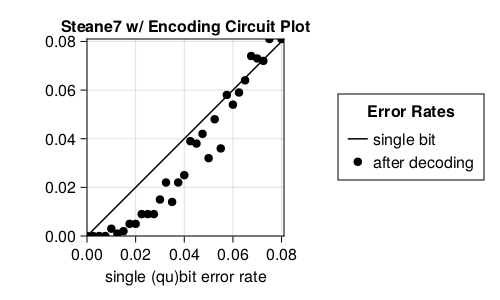

In [16]:
code = Steane7()
checks = parity_checks(code)
scirc = naive_syndrome_circuit(code)
ecirc = encoding_circuit(code)

error_rates = 0.000:0.0025:0.08
post_ec_error_rates = [evaluate_code_decoder_w_ecirc(checks, ecirc, scirc, p) for p in error_rates]
plot_code_performance(error_rates, post_ec_error_rates,title="Steane7 w/ Encoding Circuit Plot")